In [1]:
library(readxl)
#library(writexl)
library(PoissonBinomial)
library(dplyr)
library(tidyr)
library(glue)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Define a species-specific configuration as a list
species_info <- list(
  mouse = list(Dloop_range = c(15424, 16300), non_Dloop_range = c(1, 15423), Dloop_size = 877, genome_size = 16300),
  macaque = list(Dloop_range = c(16015, 16564), non_Dloop_range = c(536, 16014), Dloop_size = 1085, genome_size = 16564),
  human = list(Dloop_range = c(16024, 16569), non_Dloop_range = c(577, 16023), Dloop_size = 1122, genome_size = 16569)
)

getCoordinates <- function(df, species) {
  species_config <- species_info[[species]]
  # Retrieve the range values for the given species
  non_dloop_range <- species_config$non_Dloop_range
  dloop_range <- species_config$Dloop_range
  
  # Apply logic to classify regions based on position (POS)
  df_out <- df %>%
    mutate(
      Region = case_when(
        POS >= non_dloop_range[1] & POS <= non_dloop_range[2] ~ 'non-D',   # Within the non-D-loop range
        TRUE ~ 'D-loop'  # Any value outside the non-D-loop range is considered 'D-loop'
      )
    )
  return(df_out)
}

getDloopSize <- function(species) {
  species_config <- species_info[[species]]
  if (is.null(species_config)) stop("Invalid species")
  
  return(species_config$Dloop_size)
}

getGenomeSize <- function(species) {
  species_config <- species_info[[species]]
  if (is.null(species_config)) stop("Invalid species")
  
  return(species_config$genome_size)
}

# Headers used originally by Marzia

In [3]:
dict_marzia_headers <- list(
  Sample_ID = "sample_name",
  Individual = "Individual_ID",
  Tissue = "tissue",
  Age = "age_years",
  Age_group = "age_group",
  MeanReadDepth = "mean_depth_DCS",
  Frequency = "mut_freq",
  Species = "species",
  Region = "gene_type",
  No_mutations = "n_mutations",
  Region_size = "region_size",
  Sum_MeanReadDepths = "mean_depth_DCS",
  Nucleotides = "nt_sequenced",
  Oo_seq_100x = "Oo_seq_100x",
  Oo_seq = "Oo_seq"
)


# Parameters:

In [4]:
# # Parameters:
# SPECIES = "human"
# FILTER_VERSION = "withRepeatedPos_stricterN" #"withRepeatedPos" #"SeenJustOnce"
# DATE = "2023_05_19" #"pre_2023_05_19"
# FREQS_FILE = paste("tables/indel_freqs_",FILTER_VERSION,"_marzia_format.",DATE,".txt", sep = '')
# MUTATIONS_FILE = paste("tables/indels_all_species_",FILTER_VERSION,".",DATE,".txt", sep='')
# OUT_DIR = paste("/Users/edmundo/Documents/GitHub/mitoDUPLEX/bin/plots/", sep='')
# OUT_TABLE_DIR = paste("/Users/edmundo/Documents/GitHub/mitoDUPLEX/bin/tables/", sep='')


# Parameters:
SPECIES = "human"
ALIGNMENT = "chrM"
FREQS_FILE = glue( "tables/individuals.Dloop.denovo_{ALIGNMENT}_{SPECIES}.tab" ) # needs indel frequencies per individual at D-loop aand non-D loop
MUTATIONS_FILE = glue( "indels/indels.denovo_{ALIGNMENT}_{SPECIES}.tab" ) # all de novo mutations after main filters
# Tissues
GERM = 'Oo'
GERM_NAME = 'oocyte'
SOMA1 = 'Bl'
SOMA1_NAME = 'blood'
SOMA2 = 'Sa'
SOMA2_NAME = 'saliva'


## FREQUENCIES
# Input indel frequencies table.
mut_etg <- read.table( FREQS_FILE , header = TRUE, sep = "\t", dec = ".")
# Filter by species.
mut_etg = subset(mut_etg, (Species == SPECIES) )
# Ensure MeanReadDepth is an integer and non-negative
mut_etg$MeanReadDepth <- as.integer(mut_etg$MeanReadDepth)


## MUTATIONS
# Input indel mutations table.
mut_shared_etg <- read.table( MUTATIONS_FILE , header = TRUE, sep = "\t", dec = ".")
# Annotate D-loop info.
mut_shared_etg = getCoordinates(mut_shared_etg, SPECIES)
# Select only relevant columns and merge mutations shared by multiple oocytes of the same individual
mut_shared_etg = unique(mut_shared_etg[,c("Species","Tissue","Individual","POS","REF", "ALT","Region")])
# Concatenate columns into Marzia's format.
mut_shared_etg = mut_shared_etg %>% unite( mutation, c('POS','REF','ALT'))
mut_shared_etg = mut_shared_etg %>% unite( mut_hs, c('Individual','mutation'), remove = FALSE )
mut_shared_etg = mut_shared_etg %>% rename("Individual" = "Individual")
head(mut_etg)

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,human,hs001_Bl,Younger,Bl,hs001,1122,194,0,0.000000e+00,15447,2,6.667345e-07,16569,3217578,2,6.215856e-07,217884,2999694
2,human,hs001_Oo1,Younger,Oo,hs001,1122,1719,6,3.109115e-06,15447,0,0.000000e+00,16569,28498229,6,2.105394e-07,1929809,26568419
3,human,hs002_Oo1,Intermediate,Oo,hs002,1122,2426,0,0.000000e+00,15447,1,2.668288e-08,16569,40199384,1,2.487600e-08,2722174,37477209
4,human,hs002_Oo3,Intermediate,Oo,hs002,1122,344,2,5.173540e-06,15447,1,1.878912e-07,16569,5708811,3,5.255035e-07,386582,5322228
5,human,hs002_Oo5,Intermediate,Oo,hs002,1122,1785,7,3.494684e-06,15447,2,7.252514e-08,16569,29579686,9,3.042629e-07,2003042,27576643
6,human,hs003_Oo3,Younger,Oo,hs003,1122,1306,3,2.046091e-06,15447,5,2.476980e-07,16569,21652082,8,3.694795e-07,1466210,20185872


In [5]:
## Red to Blue
## c('#b2182b','#ef8a62','#fddbc7','#f7f7f7','#d1e5f0','#67a9cf','#2166ac')
custom_palette = c('#2166ac','#ef8a62')

# Oocytes

## Mutations shared by oocytes from different animals

### Mutation frequency estimation
We estimate the random mutation frequency per nucleotide for our oocyte samples in a conservative way, by counting only mutations found in exactly one oocyte of each individual and dividing it by the total number of sequenced nucleotides (computed as the sum over all oocytes of the mean sequencing depth for that oocyte times the mtDNA length). Since D-loop generally shows a higher mutation frequency, we estimate this frequency separately for D-loop ($p_{D}$) and for the nucleotides outside of D-loop ($p_{nonD}$). Only oocytes with mean sequencing depth of at least 100x are considered (a total of 128 oocytes among 30 individuals). 

Mutation frequency estimation:

In [6]:
mut_Oo <- subset(mut_etg, (MeanReadDepth >= 100) & (Tissue == GERM) & (Species == SPECIES) )
nrow(mut_Oo)
head(mut_Oo)

[1] 49

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>
2,human,hs001_Oo1,Younger,Oo,hs001,1122,1719,6,3.109115e-06,15447,0,0.000000e+00,16569,28498229,6,2.105394e-07,1929809,26568419
3,human,hs002_Oo1,Intermediate,Oo,hs002,1122,2426,0,0.000000e+00,15447,1,2.668288e-08,16569,40199384,1,2.487600e-08,2722174,37477209
4,human,hs002_Oo3,Intermediate,Oo,hs002,1122,344,2,5.173540e-06,15447,1,1.878912e-07,16569,5708811,3,5.255035e-07,386582,5322228
5,human,hs002_Oo5,Intermediate,Oo,hs002,1122,1785,7,3.494684e-06,15447,2,7.252514e-08,16569,29579686,9,3.042629e-07,2003042,27576643
6,human,hs003_Oo3,Younger,Oo,hs003,1122,1306,3,2.046091e-06,15447,5,2.476980e-07,16569,21652082,8,3.694795e-07,1466210,20185872
9,human,hs004_Oo2,Older,Oo,hs004,1122,1719,1,5.183989e-07,15447,2,7.530829e-08,16569,28486518,3,1.053130e-07,1929016,26557501


In [7]:
n_mut_D = mut_Oo$No_mutations_Dloop  %>% sum()
n_mut_nonD = mut_Oo$No_mutations_NonDloop  %>% sum()
nt_seq_D = mut_Oo$Nucleotides_Dloop  %>%  sum()
nt_seq_nonD = mut_Oo$Nucleotides_NonDloop  %>%  sum()

print(c( n_mut_D, n_mut_nonD, nt_seq_D ,nt_seq_nonD ))

p_D = n_mut_D / nt_seq_D 
p_nonD = n_mut_nonD / nt_seq_nonD

print(p_D)
print(p_nonD)

[1]         35        102   83238116 1145971034


[1] 4.204804e-07
[1] 8.900749e-08


We obtain a random mutation frequency $p_{D}=X.XX \times 10^{X}$ in the D-loop and $p_{nonD}=X.XX \times 10^{X}$ outside of the D-loop.

### Probability of calling a mutation in a certain oocyte
We model the process of having a random mutation in a nucleotide of a single molecule as Bernoulli trial $X \sim B(1,p)$, where the probability $p$ is $p_{D}$ for the nucleotides in the D-loop and $p_{nonD}$ for the nucleotides outside the D-loop. 

We assume that mutations occur independently in different sequenced molecules, hence the number of mutations per nucleotide in an oocyte is $Y \sim B(d,p)$, where $d$ is the mean sequencing depth of that oocyte. For each oocyte, we can then compute the probability of calling a mutation in a nucleotide as $q = P(Y \geq 1)$. 

Number of oocytes:

In [8]:
nrow(mut_Oo)

# mut_Oo %>% 
#     select('Sample_ID') %>% unique() %>% nrow()

[1] 49

Number of individuals:

In [9]:
length(unique(mut_Oo$Individual))

mut_Oo$Individual  %>% unique()  %>%  length()

[1] 22

[1] 22

Number of oocytes for each individuals:

In [10]:
n_Oo = table(mut_Oo$Individual)
sum(n_Oo)
n_Oo

[1] 49


hs001 hs002 hs003 hs004 hs005 hs006 hs007 hs008 hs009 hs010 hs011 hs012 hs014 
    1     3     1     1     2     3     3     2     3     1     2     4     3 
hs015 hs016 hs017 hs018 hs019 hs020 hs021 hs022 hs023 
    2     2     2     1     1     2     4     4     2 

Statistics of number of oocytes for each individuals:

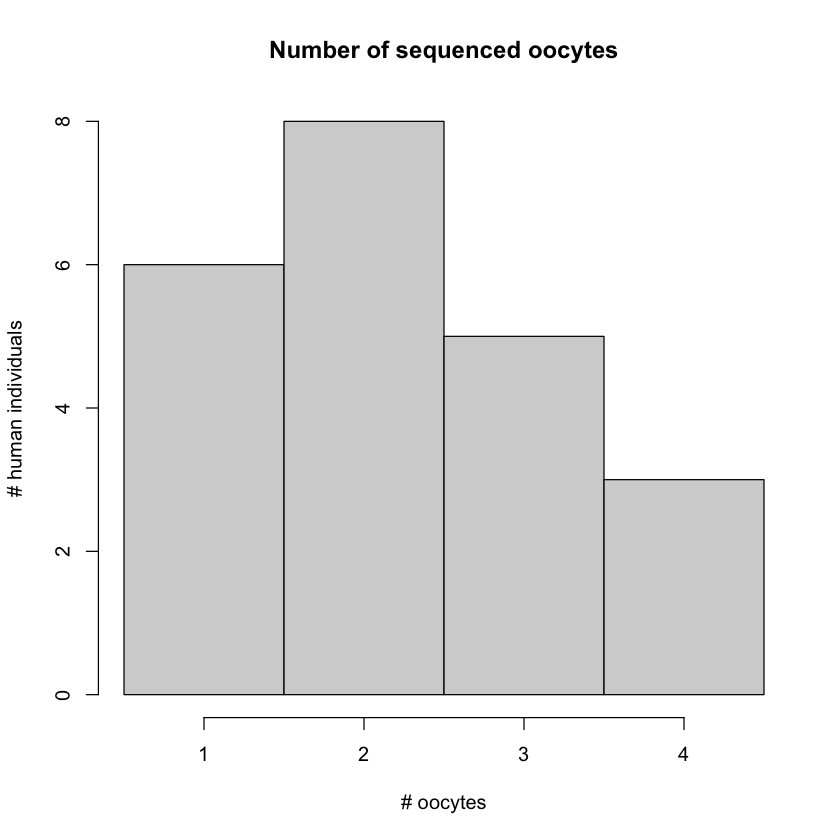

In [11]:
par(bg = "white") # global white backgrounds

hist(n_Oo, breaks = seq(0.5, max(n_Oo)+0.5), xlim = c(0,max(n_Oo))+0.5, xaxt = "n",
     main = "Number of sequenced oocytes", xlab = "# oocytes", ylab = paste("#",SPECIES,"individuals"))
axis(side = 1, at = 1:max(n_Oo))

Compute the probability of calling a mutation in a nucleotide of D-loop $q_{D}$ and in a nucleotide outside of D-loop $q_{nonD}$:

In [12]:
mut_Oo$q_D = 1 - pbinom(0, size = mut_Oo$MeanReadDepth, prob = p_D)
mut_Oo$q_nonD = 1 - pbinom(0, size = mut_Oo$MeanReadDepth, prob = p_nonD)

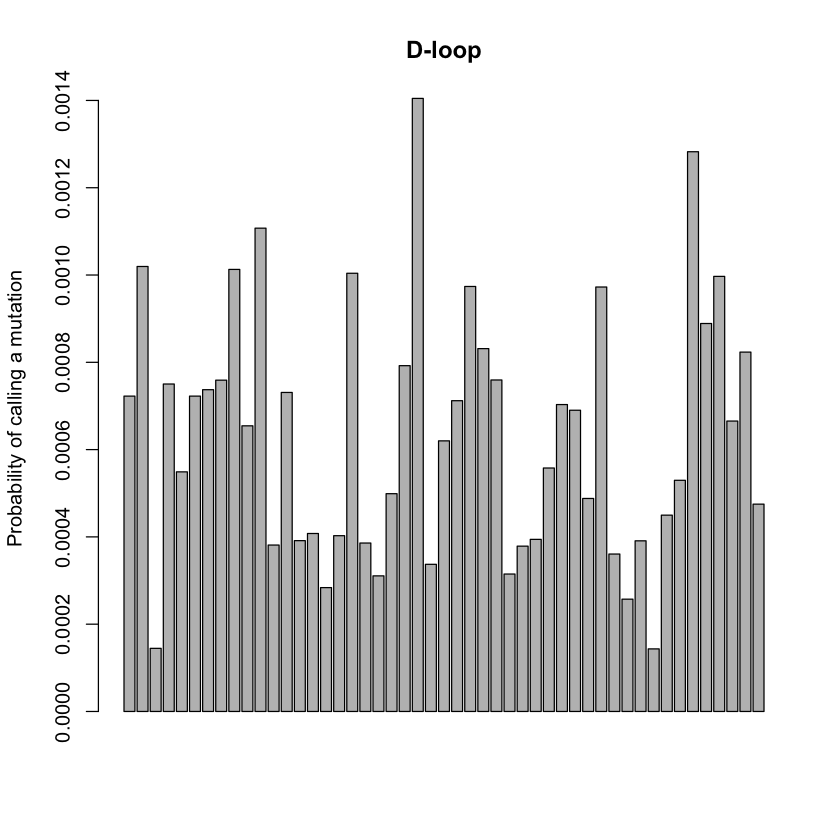

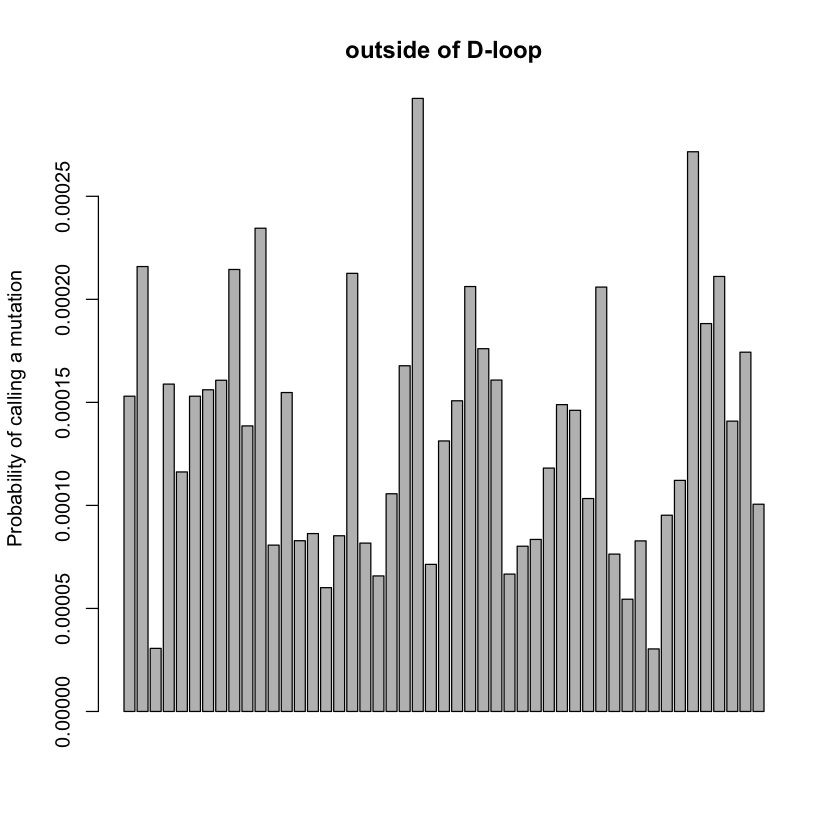

In [13]:
par(bg = "white") # global white backgrounds

barplot(mut_Oo$q_D, ylab = "Probability of calling a mutation", main = "D-loop")
barplot(mut_Oo$q_nonD, ylab = "Probability of calling a mutation", main = "outside of D-loop")

### Probability of calling a mutation for each individuals
For each individuals, we consider the number of oocyes sequenced $n_{Oo}$ (which ranges from 1 to 11). The number of oocytes of the same individuals with a mutation in a certain nucleotide is $W = W_1 + \dots + W_{n_{Oo}}$ with $W_i \sim B(1, q_i)$. Assuming independence, we can model $W$ with the Poisson binomial distribution $W \sim PB(n_{Oo}, q_1, \dots, q_{n_{Oo}})$. 
**We can then compute the probability of observing a mutation in a nucleotide in at least one oocyte of a certain individuals by random chance as $m = P(W \geq 2)$**.

In [14]:
prob_mut_Oo = cbind(tapply(mut_Oo$q_D, mut_Oo$Individual, 
                                   function(q_i){
                                     1 - ppbinom(0, probs = q_i)
                                   }), 
                            tapply(mut_Oo$q_nonD, mut_Oo$Individual, 
                                   function(q_i){
                                     1 - ppbinom(0, probs = q_i)
                                   }))
colnames(prob_mut_Oo) = c('m_D', 'm_nonD')
prob_mut_Oo

,m_D,m_nonD
hs001,0.0007225449,1.529922e-04
hs002,0.0019134558,4.053469e-04
hs003,0.0005489968,1.162370e-04
hs004,0.0007225449,1.529922e-04
hs005,0.0014957909,3.168165e-04
hs006,0.0027721629,5.874548e-04
hs007,0.0015029283,3.183291e-04
hs008,0.0006914513,1.464066e-04
hs009,0.0017917424,3.795449e-04
hs010,0.0003106868,6.577437e-05


### Probability of observing the same mutation in multiple individuals
We now consider all mutations shared by oocytes of multiple individuals. If a mutation is shared by multiple oocytes of the same individuals, we consider it only once. 

In [15]:
# Select only oocytes and individuals
mut_shared_Oo <- subset( mut_shared_etg, (Tissue == GERM) & (Species == SPECIES) )
nrow(mut_shared_Oo)
head(mut_shared_Oo)

[1] 137

,Species,Tissue,mut_hs,Individual,mutation,Region
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
3,human,Oo,hs002_5893_A_AC,hs002,5893_A_AC,non-D
4,human,Oo,hs002_14208_AACT_A,hs002,14208_AACT_A,non-D
5,human,Oo,hs002_7093_T_TC,hs002,7093_T_TC,non-D
6,human,Oo,hs002_8091_C_CTTAAAAACAGATGCAATTCCCGGACG,hs002,8091_C_CTTAAAAACAGATGCAATTCCCGGACG,non-D
7,human,Oo,hs003_1281_T_TG,hs003,1281_T_TG,non-D
8,human,Oo,hs003_1283_ATG_A,hs003,1283_ATG_A,non-D


Observed distribution of number of individuals with a certain mutation:

In [16]:
n_indivs_mut_Oo = table(mut_shared_Oo$mutation)
n_indivs_mut_Oo = table(factor(n_indivs_mut_Oo, levels = 1:max(n_indivs_mut_Oo)))
n_indivs_mut_Oo


 1  2  3 
94 20  1 

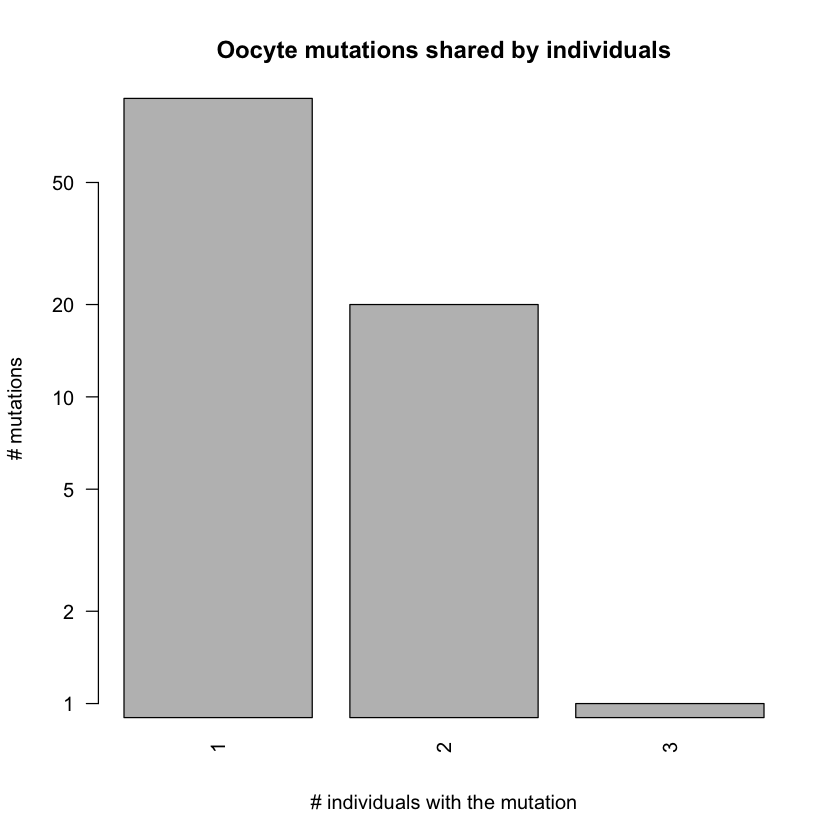

In [17]:
par(bg = "white") # global white backgrounds

n_indivs_mut_Oo_NA = n_indivs_mut_Oo
n_indivs_mut_Oo_NA[n_indivs_mut_Oo_NA==0] = NA
barplot(n_indivs_mut_Oo_NA, log = "y", xlab = "# individuals with the mutation", 
        ylab = "# mutations", main = "Oocyte mutations shared by individuals", las = 2)

Total number of mutations shared by multiple individuals:

In [18]:
sum(n_indivs_mut_Oo[2:length(n_indivs_mut_Oo)])

[1] 21

Select only mutations shared by multiple individuals:

In [19]:
n_hs = as.data.frame(table(mut_shared_Oo$mutation))
colnames(n_hs) = c("mutation", "n_hs")
mut_shared_Oo = merge(mut_shared_Oo, n_hs, by = "mutation")
mut_shared_Oo = mut_shared_Oo[mut_shared_Oo$n_hs>1,]
mut_shared_Oo = drop_na(mut_shared_Oo)
head(mut_shared_Oo)

,mutation,Species,Tissue,mut_hs,Individual,Region,n_hs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,1281_T_TG,human,Oo,hs003_1281_T_TG,hs003,non-D,2
2,1281_T_TG,human,Oo,hs007_1281_T_TG,hs007,non-D,2
3,16186_CCT_C,human,Oo,hs002_16186_CCT_C,hs002,D-loop,2
4,16186_CCT_C,human,Oo,hs003_16186_CCT_C,hs003,D-loop,2
5,16188_T_TC,human,Oo,hs002_16188_T_TC,hs002,D-loop,2
6,16188_T_TC,human,Oo,hs005_16188_T_TC,hs005,D-loop,2


Check the total number of mutations shared by multiple individuals:

In [20]:
length(unique(mut_shared_Oo$mutation))

[1] 21

Total number of mutations shared by multiple individuals inside and outside D-loop:

In [21]:
mut_shared_Oo_unique = unique(mut_shared_Oo[,c("mutation", "Region")])
c(length(mut_shared_Oo_unique$mutation[mut_shared_Oo_unique$Region=="D-loop"]), 
  length(mut_shared_Oo_unique$mutation[mut_shared_Oo_unique$Region!="D-loop"]))

[1]  9 12

We consider the number of individuals with sequenced oocytes $n_{hs}=X$. The number of individuals with a mutation in a certain nucleotide is $V = V_1 + \dots + V_{n_{hs}}$ with $V_i \sim B(1, m_i)$. Assuming independence, we can model $V$ with the Poisson binomial distribution $V \sim PB(n_{hs}, m_1, \dots, m_{n_{hs}})$. 
**We can then compute the probability of observing a mutation in one, two or more individuals by random chance as $P(V=v)$ for $v=1, \dots, n_{hs}$**.

In [22]:
n_hs = length(unique(mut_shared_Oo$Individual))
n_hs

prob_shared_Oo_hs = cbind(dpbinom(1:n_hs, probs = prob_mut_Oo[,"m_D"]), 
                      dpbinom(1:n_hs, probs = prob_mut_Oo[,"m_nonD"]))
colnames(prob_shared_Oo_hs) = c('P(V=v)_D', 'P(V=v)_nonD')
row.names(prob_shared_Oo_hs) = 1:n_hs
prob_shared_Oo_hs

[1] 17

,P(V=v)_D,P(V=v)_nonD
1,3.025649e-02,6.558931e-03
2,4.419486e-04,2.026456e-05
3,4.019539e-06,3.898562e-08
4,2.555022e-08,5.241997e-11
5,1.207642e-10,5.241134e-14
6,4.408298e-13,4.047182e-17
7,1.274054e-15,2.474424e-20
8,2.964828e-18,1.218147e-23
9,5.618943e-21,4.884021e-27
10,8.736951e-24,1.606624e-30


### Expected number of shared mutations
Finally, we can compute the expected number of random mutations present at the same site in one, two or more individuals by multiplying the probability $P(V=v)$ by the mtDNA length (i.e., 1085 nucleotides for D-loop and 15479 nucleotides outside of D-loop). 

In [23]:
nt_D = mut_Oo$Region_size_Dloop[1]
nt_nonD = mut_Oo$Region_size_NonDloop[1]

expected_shared_Oo_hs = t(t(prob_shared_Oo_hs) * c(nt_D, nt_nonD))
expected_shared_Oo_hs = cbind(expected_shared_Oo_hs, rowSums(expected_shared_Oo_hs))
colnames(expected_shared_Oo_hs) = c('exp_mut_D', 'exp_mut_nonD', 'exp_mut_tot')
expected_shared_Oo_hs

,exp_mut_D,exp_mut_nonD,exp_mut_tot
1,3.394778e+01,1.013158e+02,1.352636e+02
2,4.958664e-01,3.130267e-01,8.088931e-01
3,4.509923e-03,6.022109e-04,5.112134e-03
4,2.866734e-05,8.097314e-07,2.947708e-05
5,1.354975e-07,8.095979e-10,1.363071e-07
6,4.946111e-10,6.251682e-13,4.952362e-10
7,1.429489e-12,3.822243e-16,1.429871e-12
8,3.326536e-15,1.881671e-19,3.326725e-15
9,6.304454e-18,7.544348e-23,6.304529e-18
10,9.802859e-21,2.481752e-26,9.802884e-21


Observed number of shared mutations:

In [24]:
shared_Oo_hs = cbind(expected_shared_Oo_hs, 
                     c(n_indivs_mut_Oo_NA, rep(NA, n_hs-length(n_indivs_mut_Oo_NA))), 0)
colnames(shared_Oo_hs)[4:5] = c("obs_mut_tot", "delta")
shared_Oo_hs[,"delta"] = shared_Oo_hs[,"obs_mut_tot"] - shared_Oo_hs[,"exp_mut_tot"]
shared_Oo_hs

,exp_mut_D,exp_mut_nonD,exp_mut_tot,obs_mut_tot,delta
1,3.394778e+01,1.013158e+02,1.352636e+02,94,-41.2635899
2,4.958664e-01,3.130267e-01,8.088931e-01,20,19.1911069
3,4.509923e-03,6.022109e-04,5.112134e-03,1,0.9948879
4,2.866734e-05,8.097314e-07,2.947708e-05,NA,NA
5,1.354975e-07,8.095979e-10,1.363071e-07,NA,NA
6,4.946111e-10,6.251682e-13,4.952362e-10,NA,NA
7,1.429489e-12,3.822243e-16,1.429871e-12,NA,NA
8,3.326536e-15,1.881671e-19,3.326725e-15,NA,NA
9,6.304454e-18,7.544348e-23,6.304529e-18,NA,NA
10,9.802859e-21,2.481752e-26,9.802884e-21,NA,NA


Total number of expected shared mutations:

In [25]:
colSums(shared_Oo_hs[-1,], na.rm = TRUE)

exp_mut_D exp_mut_nonD  exp_mut_tot  obs_mut_tot        delta 
   0.5004051    0.3136297    0.8140348   21.0000000   20.1859948

**We expect to observe around XX mutation sites shared by different individuals (X in D-loop and X outside D-loop). We actually observe XX shared sites (XX in D-loop and X outside D-loop).**

pdf 
  2

null device 
          1

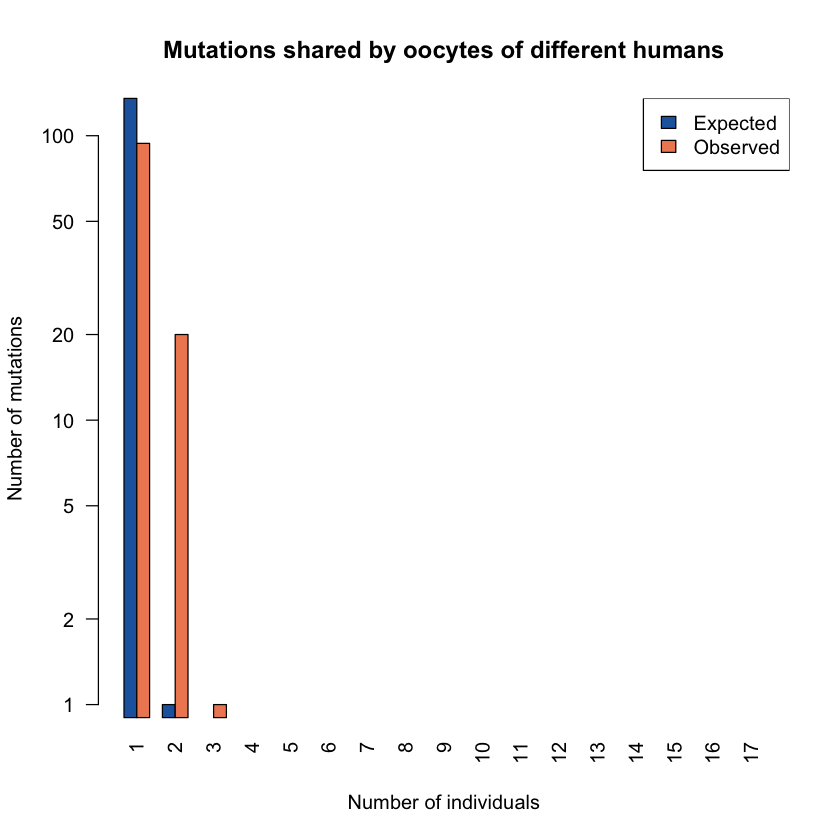

In [26]:
shared_Oo_hs_NA = shared_Oo_hs[,c("exp_mut_tot","obs_mut_tot")]
shared_Oo_hs_NA[shared_Oo_hs_NA<0.5] = NA
shared_Oo_hs_NA[shared_Oo_hs_NA<1 & shared_Oo_hs_NA>0.5] = 1


par(bg = "white") # global white backgrounds

barplot(t(shared_Oo_hs_NA), xlab = "Number of individuals", ylab = "Number of mutations", 
        main = paste("Mutations shared by oocytes of different ",SPECIES,'s', sep=''), log = "y", 
        beside = TRUE, col = custom_palette , las = 2)
legend("topright", legend = c("Expected", "Observed"), fill = custom_palette )

# Output plot.
dev.copy2pdf( file= glue("variantHotspots/barplot_sharedMutations_{ALIGNMENT}_{SPECIES}_{GERM}.pdf") )
dev.off()

# Export data table.
write.table(shared_Oo_hs_NA, file = glue("variantHotspots/sharedMutations_{ALIGNMENT}_{SPECIES}_{GERM}.txt"),
             sep = "\t", row.names = TRUE, col.names = TRUE)

### Hotspot mutations identification
In order to better identify the hotspot mutations, i.e. the mutations that are shared by multiple individuals but are not expected to be shared, we consider each of 26 shared mutations and we compute the probability of observing it exactly in those individuals in which we are observing it. This way, we can rank the shared mutations based on how unusual they are, taking into consideration in which individuals we found them (hence, also the number of oocytes sequenced for those individuals and their sequencing depth). 

For each of the 26 shared mutation, we consider the $n_{hs,i}$ individuals in which we observed it. If the mutation is present in the individuals $j, \dots, j_{n_{hs,i}}$ and is not present in the individuals $k, \dots, k_{n_{hs}-n_{hs,i}}$, assuming independence among random mutations in differentindividuals we obtain that the probability of observing such a mutation in exactly those individuals is $m_j \times \cdots \times m_{j_{n_{hs,i}}} \times (1-m_k) \times \cdots \times (1-m_{k_{n_{hs}-n_{hs,i}}})$. 

In [27]:


mut_shared_Oo_prob = unique(mut_shared_Oo[,c("mutation", "Region", "n_hs")])
mut_shared_Oo_prob$prob = unlist(lapply(unique(mut_shared_Oo$mutation), 
                                     function(mutation){
                                       mut_shared_i = mut_shared_Oo[mut_shared_Oo$mutation==mutation,]
                                       if(!is.na(mut_shared_i$Region[1]) && mut_shared_i$Region[1]=="D-loop"){
                                         m = prob_mut_Oo[,"m_D"]
                                       }else{
                                         m = prob_mut_Oo[,"m_nonD"]
                                       }
                                       j = names(m) %in% mut_shared_i$Individual
                                       return(prod(c(m[j], (1-m[!j]))))
                                     }))
mut_shared_Oo_prob = mut_shared_Oo_prob[order(mut_shared_Oo_prob$prob),]
mut_shared_Oo_prob

# Export data table.
write.table(mut_shared_Oo_prob, 
    file = glue("variantHotspots/variantHotspots_{ALIGNMENT}_{SPECIES}_{GERM}.txt"), 
    sep = "\t", row.names = TRUE, col.names = TRUE)

,mutation,Region,n_hs,prob
,<chr>,<chr>,<int>,<dbl>
23,55_A_AT,D-loop,3,2.411796e-09
32,5746_A_AG,non-D,2,1.787004e-08
40,7474_G_GA,non-D,2,1.796895e-08
36,6181_GT_G,non-D,2,2.094777e-08
42,8267_AGCACCCCCT_A,non-D,2,2.232602e-08
38,7464_A_AC,non-D,2,2.932892e-08
34,5873_TC_T,non-D,2,3.550056e-08
1,1281_T_TG,non-D,2,3.677417e-08
19,5528_AC_A,non-D,2,4.255410e-08


Save results:

In [28]:
#write_xlsx(mut_shared_Oo_prob, "shared_mutation_multiple_hs_oocytes.xlsx")

# Blood - Somatic tissue 1

## Mutations shared by "Somatic 1" from different animals

### Mutation frequency estimation
The random mutation frequency per nucleotide estimation is done similarly to the oocyte case, by counting all mutations found in "Somatic 1" Tissue (in all 30 individuals, since the mean sequencing depth is pretty high for all of them) and dividing it by the total number of sequenced nucleotides. The random mutation frequency is estimated separately for D-loop. 

Mutation frequency estimation:

In [29]:
# select only"Somatic 1"samples with mean depth >= 100x
mut_soma1 <- subset(mut_etg, (MeanReadDepth >= 100) & (Tissue == SOMA1) & (Species == SPECIES) )

head(mut_soma1)

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,human,hs001_Bl,Younger,Bl,hs001,1122,194,0,0.000000e+00,15447,2,6.667345e-07,16569,3217578,2,6.215856e-07,217884,2999694
8,human,hs004_Bl,Older,Bl,hs004,1122,511,2,3.484440e-06,15447,8,1.012376e-06,16569,8476186,10,1.179776e-06,573980,7902205
19,human,hs008_Bl,Younger,Bl,hs008,1122,139,1,6.404847e-06,15447,3,1.395657e-06,16569,2305657,4,1.734863e-06,156131,2149525
50,human,hs022_Bl,Intermediate,Bl,hs022,1122,255,0,0.000000e+00,15447,6,1.518910e-06,16569,4237126,6,1.416054e-06,286924,3950201


In [30]:

# # Marzia blood
# n_mut_D = 980
# n_mut_nonD = 8409
# nt_seq_D = 94745455
# nt_seq_nonD = 1351672717

n_mut_D = mut_soma1$No_mutations_Dloop  %>% sum()
n_mut_nonD = mut_soma1$No_mutations_NonDloop  %>% sum()
nt_seq_D = mut_soma1$Nucleotides_Dloop  %>%  sum()
nt_seq_nonD = mut_soma1$Nucleotides_NonDloop  %>%  sum()

print(c( n_mut_D, n_mut_nonD, nt_seq_D ,nt_seq_nonD ))

p_D = n_mut_D / nt_seq_D 
p_nonD = n_mut_nonD / nt_seq_nonD

print(p_D)
print(p_nonD)

[1]        3       19  1234919 17001625
[1] 2.429309e-06
[1] 1.11754e-06


We obtain a random mutation frequency $p_{D}=X.XX\times 10^{X}$ in the D-loop and $p_{nonD}=8.69 \times 10^{X}$ outside of the D-loop.

### Probability of calling a mutation for each individuals
As above, we model the process of having a random mutation in a nucleotide of a single molecule as Bernoulli trial $X \sim B(1,p)$, where the probability $p$ is $p_{D}$ for the nucleotides in the D-loop and $p_{nonD}$ for the nucleotides outside the D-loop. 

We assume that mutations occur independently in different sequenced molecules, hence the number of mutations per nucleotide in a"Somatic 1"sample is $Y \sim B(d,p)$, where $d$ is the mean sequencing depth of that"Somatic 1"sample. For each"Somatic 1"sample, we can then compute the probability of calling a mutation in a nucleotide as $q = P(Y \geq 1)$. 

Number of individuals:

In [31]:
length(unique(mut_soma1$Individual))

[1] 4

Compute the probability of calling a mutation in a nucleotide of D-loop $q_{D}$ and in a nucleotide outside of D-loop $q_{nonD}$:

In [32]:
mut_soma1$q_D = 1 - pbinom(0, size = mut_soma1$MeanReadDepth, prob = p_D)
mut_soma1$q_nonD = 1 - pbinom(0, size = mut_soma1$MeanReadDepth, prob = p_nonD)

In [33]:
mut_soma1

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop,q_D,q_nonD
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,human,hs001_Bl,Younger,Bl,hs001,1122,194,0,0.000000e+00,15447,2,6.667345e-07,16569,3217578,2,6.215856e-07,217884,2999694,0.0004711755,0.0002167794
8,human,hs004_Bl,Older,Bl,hs004,1122,511,2,3.484440e-06,15447,8,1.012376e-06,16569,8476186,10,1.179776e-06,573980,7902205,0.0012406083,0.0005709004
19,human,hs008_Bl,Younger,Bl,hs008,1122,139,1,6.404847e-06,15447,3,1.395657e-06,16569,2305657,4,1.734863e-06,156131,2149525,0.0003376174,0.0001553261
50,human,hs022_Bl,Intermediate,Bl,hs022,1122,255,0,0.000000e+00,15447,6,1.518910e-06,16569,4237126,6,1.416054e-06,286924,3950201,0.0006192827,0.0002849323


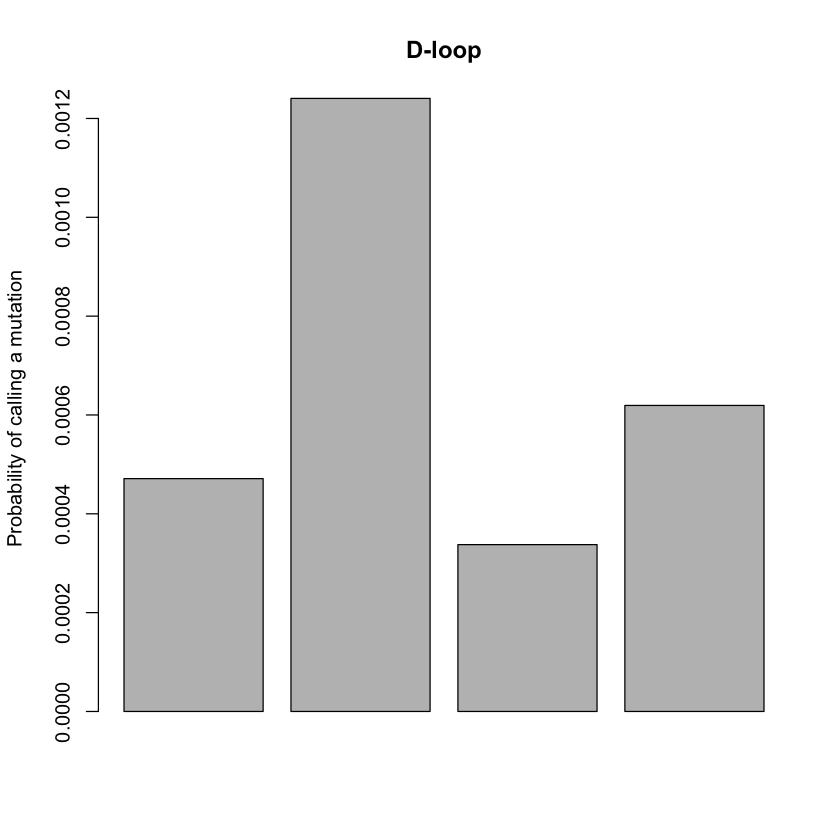

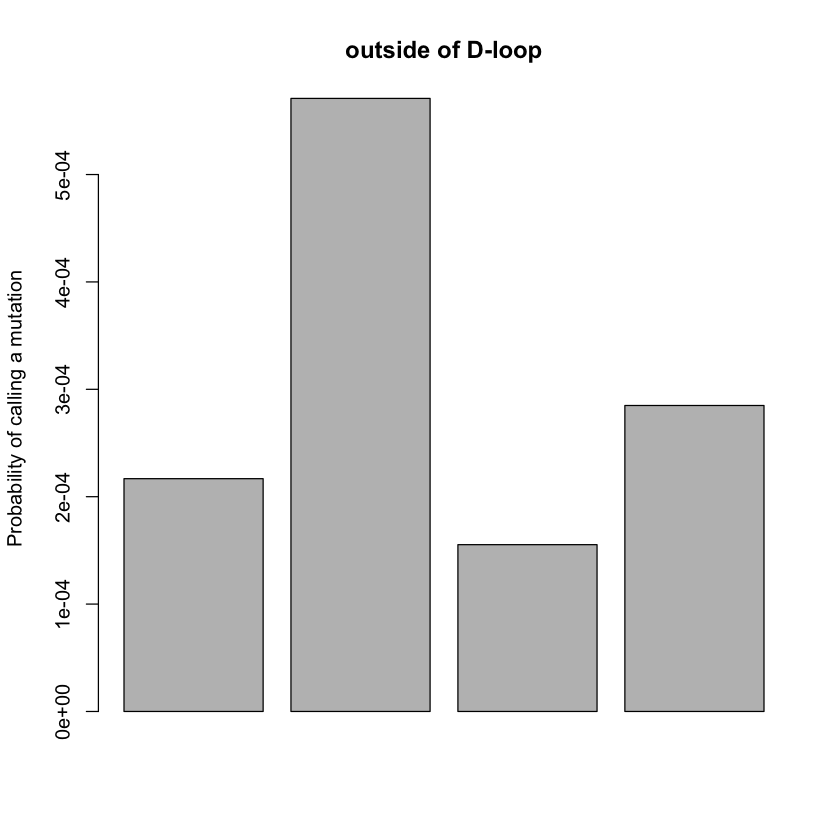

In [34]:
par(bg = "white") # global white backgrounds

barplot(mut_soma1$q_D, ylab = "Probability of calling a mutation", main = "D-loop")
barplot(mut_soma1$q_nonD, ylab = "Probability of calling a mutation", main = "outside of D-loop")

### Probability of observing the same mutation in multiple individuals
We now consider all mutations shared by"Somatic 1"samples of multiple individuals. 

In [35]:
# select only "Somatic 1"
mut_shared_soma1 <- subset(mut_shared_etg, (Tissue == SOMA1) & (Species == SPECIES) )
head(mut_shared_soma1)

,Species,Tissue,mut_hs,Individual,mutation,Region
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,human,Bl,hs001_11865_A_AC,hs001,11865_A_AC,non-D
2,human,Bl,hs001_14618_A_AC,hs001,14618_A_AC,non-D
15,human,Bl,hs004_1194_CT_C,hs004,1194_CT_C,non-D
16,human,Bl,hs004_1900_A_AC,hs004,1900_A_AC,non-D
17,human,Bl,hs004_5745_G_GA,hs004,5745_G_GA,non-D
18,human,Bl,hs004_5883_AT_A,hs004,5883_AT_A,non-D


Observed distribution of number of individuals with a certain mutation:

In [36]:
n_indivs_mut_soma1 = table(mut_shared_soma1$mutation)
n_indivs_mut_soma1 = table(factor(n_indivs_mut_soma1, levels = 1:max(n_indivs_mut_soma1)))
n_indivs_mut_soma1


 1  2 
20  1 

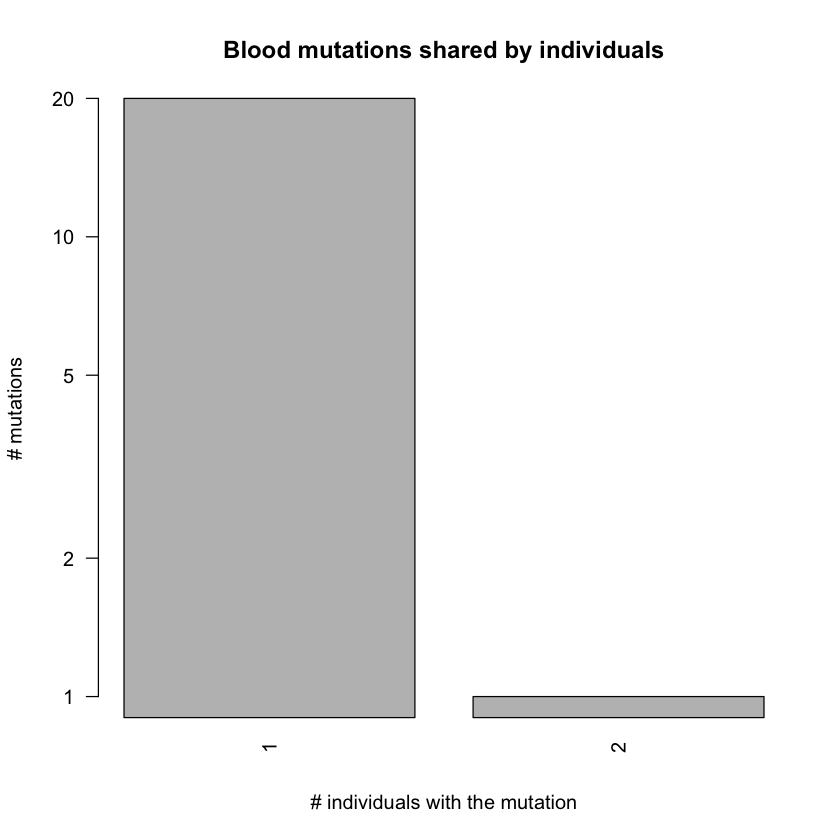

In [37]:
par(bg = "white") # global white backgrounds

n_indivs_mut_soma1_NA = n_indivs_mut_soma1
n_indivs_mut_soma1_NA[n_indivs_mut_soma1_NA==0] = NA
barplot(n_indivs_mut_soma1_NA, log = "y", xlab = "# individuals with the mutation", 
        ylab = "# mutations", main = "Blood mutations shared by individuals", las = 2)

Total number of mutations shared by multiple individuals:

In [38]:
sum(n_indivs_mut_soma1[2:length(n_indivs_mut_soma1)])

[1] 1

Select only mutations shared by multiple individuals:

In [39]:
n_hs = as.data.frame(table(mut_shared_soma1$mutation))
colnames(n_hs) = c("mutation", "n_hs")
mut_shared_soma1 = merge(mut_shared_soma1, n_hs, by = "mutation")
mut_shared_soma1 = mut_shared_soma1[mut_shared_soma1$n_hs>1,]
mut_shared_soma1 = drop_na(mut_shared_soma1)
head(mut_shared_soma1)

,mutation,Species,Tissue,mut_hs,Individual,Region,n_hs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,11865_A_AC,human,Bl,hs001_11865_A_AC,hs001,non-D,2
2,11865_A_AC,human,Bl,hs022_11865_A_AC,hs022,non-D,2


Check the total number of mutations shared by multiple individuals:

In [40]:
length(unique(mut_shared_soma1$mutation))

[1] 1

Total number of mutations shared by multiple individuals inside and outside D-loop:

In [41]:
mut_shared_soma1_unique = unique(mut_shared_soma1[,c("mutation", "Region")])
c(length(mut_shared_soma1_unique$mutation[mut_shared_soma1_unique$Region=="D-loop"]), 
  length(mut_shared_soma1_unique$mutation[mut_shared_soma1_unique$Region!="D-loop"]))

[1] 0 1

We consider the number of individuals with sequenced"Somatic 1"$n_{hs}=30$. The number of individuals with a mutation in a certain nucleotide is $V = V_1 + \dots + V_{n_{hs}}$ with $V_i \sim B(1, q_i)$. Assuming independence, we can model $V$ with the Poisson binomial distribution $V \sim PB(n_{hs}, q_1, \dots, q_{n_{hs}})$. 
**We can then compute the probability of observing a mutation in one, two or more individuals by random chance as $P(V=v)$ for $v=1, \dots, n_{hs}$**.

In [42]:
n_hs = length(unique(mut_shared_soma1$Individual))
n_hs

prob_shared_soma1_hs = cbind(dpbinom(1:n_hs, probs = mut_soma1$q_D), 
                             dpbinom(1:n_hs, probs = mut_soma1$q_nonD))
colnames(prob_shared_soma1_hs) = c('P(V=v)_D', 'P(V=v)_nonD')
row.names(prob_shared_soma1_hs) = 1:n_hs
prob_shared_soma1_hs

[1] 2

,P(V=v)_D,P(V=v)_nonD
1,2.663823e-03,1.226909e-03
2,2.428880e-06,5.145315e-07


### Expected number of shared mutations
Finally, we can compute the expected number of random mutations present at the same site in one, two or more individuals by multiplying the probability $P(V=v)$ by the mtDNA length (i.e., 1085 nucleotides for D-loop and 15479 nucleotides outside of D-loop). 

In [43]:
nt_D = mut_Oo$Region_size_Dloop[1]
nt_nonD = mut_Oo$Region_size_NonDloop[1]

expected_shared_soma1_hs = t(t(prob_shared_soma1_hs) * c(nt_D, nt_nonD))
expected_shared_soma1_hs = cbind(expected_shared_soma1_hs, rowSums(expected_shared_soma1_hs))
colnames(expected_shared_soma1_hs) = c('exp_mut_D', 'exp_mut_nonD', 'exp_mut_tot')
expected_shared_soma1_hs

,exp_mut_D,exp_mut_nonD,exp_mut_tot
1,2.988809849,18.952061510,21.94087136
2,0.002725203,0.007947969,0.01067317


Observed number of shared mutations:

In [44]:
shared_soma1_hs = cbind(expected_shared_soma1_hs, 
                        c(n_indivs_mut_soma1_NA, 
                          rep(NA, n_hs-length(n_indivs_mut_soma1_NA))), 0)
colnames(shared_soma1_hs)[4:5] = c("obs_mut_tot", "delta")
shared_soma1_hs[,"delta"] = shared_soma1_hs[,"obs_mut_tot"] - shared_soma1_hs[,"exp_mut_tot"]
shared_soma1_hs

,exp_mut_D,exp_mut_nonD,exp_mut_tot,obs_mut_tot,delta
1,2.988809849,18.952061510,21.94087136,20,-1.9408714
2,0.002725203,0.007947969,0.01067317,1,0.9893268


Total number of expected shared mutations:

In [45]:
#colSums(shared_soma1_hs[-1,], na.rm = TRUE)

**We expect to observe around 9 mutation sites shared by different individuals (9 in D-loop and 0 outside D-loop). We actually observe 80 shared sites (XX in D-loop and X outside D-loop).**

pdf 
  2

null device 
          1

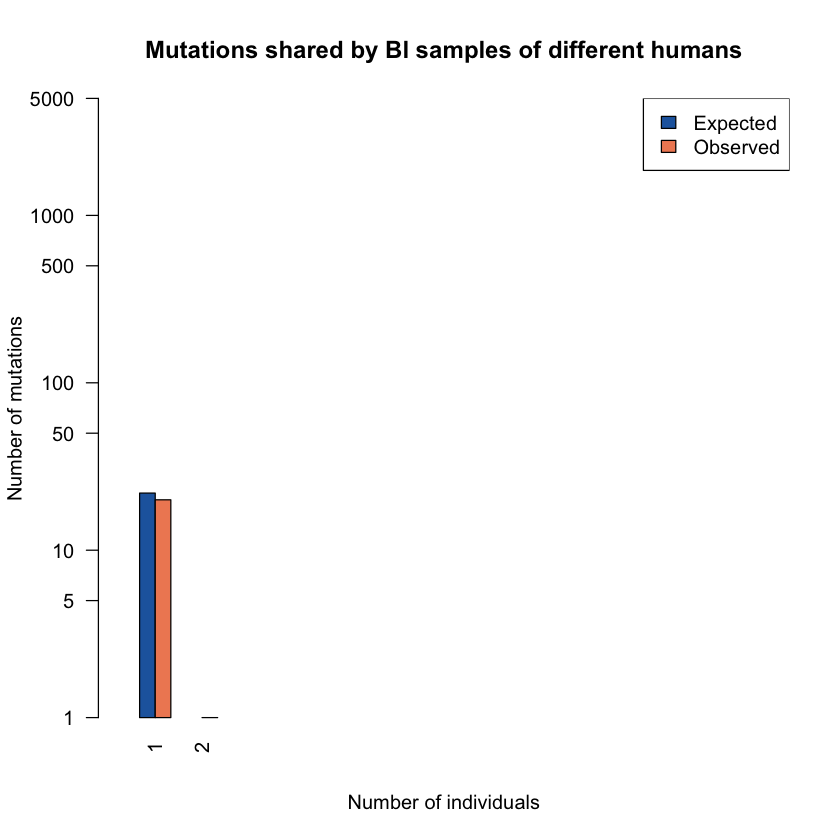

In [46]:
shared_soma1_hs_NA = shared_soma1_hs[,c("exp_mut_tot","obs_mut_tot")]
shared_soma1_hs_NA[shared_soma1_hs_NA<0.5] = NA
shared_soma1_hs_NA[shared_soma1_hs_NA<1 & shared_soma1_hs_NA>0.5] = 1


par(bg = "white") # global white backgrounds

barplot(t(shared_soma1_hs_NA), xlab = "Number of individuals", ylab = "Number of mutations", 
        main = glue("Mutations shared by {SOMA1} samples of different {SPECIES}s"), log = "y", 
        xlim = c(0,41), ylim = c(1,5000), beside = TRUE, col = custom_palette , las = 2)
legend("topright", legend = c("Expected", "Observed"), fill = custom_palette)

# Output plot.
dev.copy2pdf( file = glue("variantHotspots/barplot_sharedMutations_{ALIGNMENT}_{SPECIES}_{SOMA1}.pdf") )
dev.off()

# Export data table.
write.table(shared_soma1_hs_NA, file = glue("variantHotspots/sharedMutations_{ALIGNMENT}_{SPECIES}_{SOMA1}.txt")
            , sep = "\t", row.names = TRUE, col.names = TRUE)

### Hotspot mutations identification
In order to better identify the hotspot mutations, i.e. the mutations that are shared by multiple individuals but are not expected to be shared, we consider each of 80 shared mutations and we compute the probability of observing it exactly in those individuals in which we are observing it. This way, we can rank the shared mutations based on how unusual they are, taking into consideration in which individuals we found them (hence, also the sequencing depth for each sample). 

For each of the 80 shared mutation, we consider the $n_{hs,i}$ individuals in which we observed it. If the mutation is present in the individuals $j, \dots, j_{n_{hs,i}}$ and is not present in the individuals $k, \dots, k_{n_{hs}-n_{hs,i}}$, assuming independence among random mutations in differentindividuals we obtain that the probability of observing such a mutation in exactly those individuals is $q_j \times \cdots \times q_{j_{n_{hs,i}}} \times (1-q_k) \times \cdots \times (1-q_{k_{n_{hs}-n_{hs,i}}})$. 

In [47]:
mut_shared_soma1_prob = unique(mut_shared_soma1[,c("mutation", "Region", "n_hs")])
mut_shared_soma1_prob$prob = unlist(lapply(unique(mut_shared_soma1$mutation), 
                                           function(mutation){
                                             mut_shared_i = mut_shared_soma1[mut_shared_soma1$mutation==mutation,]
                                             if(mut_shared_i$Region[1]=="D-loop"){
                                               q = mut_soma1$q_D
                                             }else{
                                               q = mut_soma1$q_nonD
                                             }
                                             j = mut_soma1$Individual %in% mut_shared_i$Individual
                                             return(prod(c(q[j], (1-q[!j]))))
                                           }))
mut_shared_soma1_prob = mut_shared_soma1_prob[order(mut_shared_soma1_prob$prob),]
mut_shared_soma1_prob

# Export data table.
write.table(mut_shared_soma1_prob, 
    file = glue("variantHotspots/variantHotspots_{ALIGNMENT}_{SPECIES}_{SOMA1}.txt"), 
    sep = "\t", row.names = TRUE, col.names = TRUE)

,mutation,Region,n_hs,prob
,<chr>,<chr>,<int>,<dbl>
1,11865_A_AC,non-D,2,6.172261e-08


# Saliva - Somatic Tissue 2

## Mutations shared by "Somatic 2" from different animals

### Mutation frequency estimation
The random mutation frequency per nucleotide estimation is done similarly to the oocyte case, by counting all mutations found in "Somatic 2" Tissue (in all 30 individuals, since the mean sequencing depth is pretty high for all of them) and dividing it by the total number of sequenced nucleotides. The random mutation frequency is estimated separately for D-loop. 

Mutation frequency estimation:

In [48]:
# select only "Somatic 2" samples with mean depth >= 100x
mut_soma2 <- subset(mut_etg, (MeanReadDepth >= 100) & (Tissue == SOMA2) & (Species == SPECIES) )

head(mut_soma2)

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>
7,human,hs003_Sa,Younger,Sa,hs003,1122,186,1,4.780350e-06,15447,4,1.388892e-06,16569,3089184,5,1.618550e-06,209189,2879994
12,human,hs005_Sa,Younger,Sa,hs005,1122,233,0,0.000000e+00,15447,2,5.556696e-07,16569,3860695,2,5.180414e-07,261433,3599261
32,human,hs012_Sa,Older,Sa,hs012,1122,391,1,2.276535e-06,15447,5,8.267859e-07,16569,6486779,6,9.249583e-07,439264,6047514
57,human,hs023_Sa,Intermediate,Sa,hs023,1122,585,0,0.000000e+00,15447,11,1.216096e-06,16569,9702348,11,1.133746e-06,657012,9045335


In [49]:

# # Marzia blood
# n_mut_D = 980
# n_mut_nonD = 8409
# nt_seq_D = 94745455
# nt_seq_nonD = 1351672717

n_mut_D = mut_soma2$No_mutations_Dloop  %>% sum()
n_mut_nonD = mut_soma2$No_mutations_NonDloop  %>% sum()
nt_seq_D = mut_soma2$Nucleotides_Dloop  %>%  sum()
nt_seq_nonD = mut_soma2$Nucleotides_NonDloop  %>%  sum()

print(c( n_mut_D, n_mut_nonD, nt_seq_D ,nt_seq_nonD ))

p_D = n_mut_D / nt_seq_D 
p_nonD = n_mut_nonD / nt_seq_nonD

print(p_D)
print(p_nonD)

[1]        2       22  1566898 21572104
[1] 1.276407e-06
[1] 1.019836e-06


We obtain a random mutation frequency $p_{D}=X.XX\times 10^{X}$ in the D-loop and $p_{nonD}=8.69 \times 10^{X}$ outside of the D-loop.

### Probability of calling a mutation for each individuals
As above, we model the process of having a random mutation in a nucleotide of a single molecule as Bernoulli trial $X \sim B(1,p)$, where the probability $p$ is $p_{D}$ for the nucleotides in the D-loop and $p_{nonD}$ for the nucleotides outside the D-loop. 

We assume that mutations occur independently in different sequenced molecules, hence the number of mutations per nucleotide in a"Somatic 1"sample is $Y \sim B(d,p)$, where $d$ is the mean sequencing depth of that"Somatic 1"sample. For each"Somatic 1"sample, we can then compute the probability of calling a mutation in a nucleotide as $q = P(Y \geq 1)$. 

Number of individuals:

In [50]:
length(unique(mut_soma2$Individual))

[1] 4

Compute the probability of calling a mutation in a nucleotide of D-loop $q_{D}$ and in a nucleotide outside of D-loop $q_{nonD}$:

In [51]:
mut_soma2$q_D = 1 - pbinom(0, size = mut_soma2$MeanReadDepth, prob = p_D)
mut_soma2$q_nonD = 1 - pbinom(0, size = mut_soma2$MeanReadDepth, prob = p_nonD)

In [52]:
mut_soma2

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop,q_D,q_nonD
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
7,human,hs003_Sa,Younger,Sa,hs003,1122,186,1,4.780350e-06,15447,4,1.388892e-06,16569,3089184,5,1.618550e-06,209189,2879994,0.0002373837,0.0001896715
12,human,hs005_Sa,Younger,Sa,hs005,1122,233,0,0.000000e+00,15447,2,5.556696e-07,16569,3860695,2,5.180414e-07,261433,3599261,0.0002973589,0.0002375936
32,human,hs012_Sa,Older,Sa,hs012,1122,391,1,2.276535e-06,15447,5,8.267859e-07,16569,6486779,6,9.249583e-07,439264,6047514,0.0004989510,0.0003986764
57,human,hs023_Sa,Intermediate,Sa,hs023,1122,585,0,0.000000e+00,15447,11,1.216096e-06,16569,9702348,11,1.133746e-06,657012,9045335,0.0007464200,0.0005964262


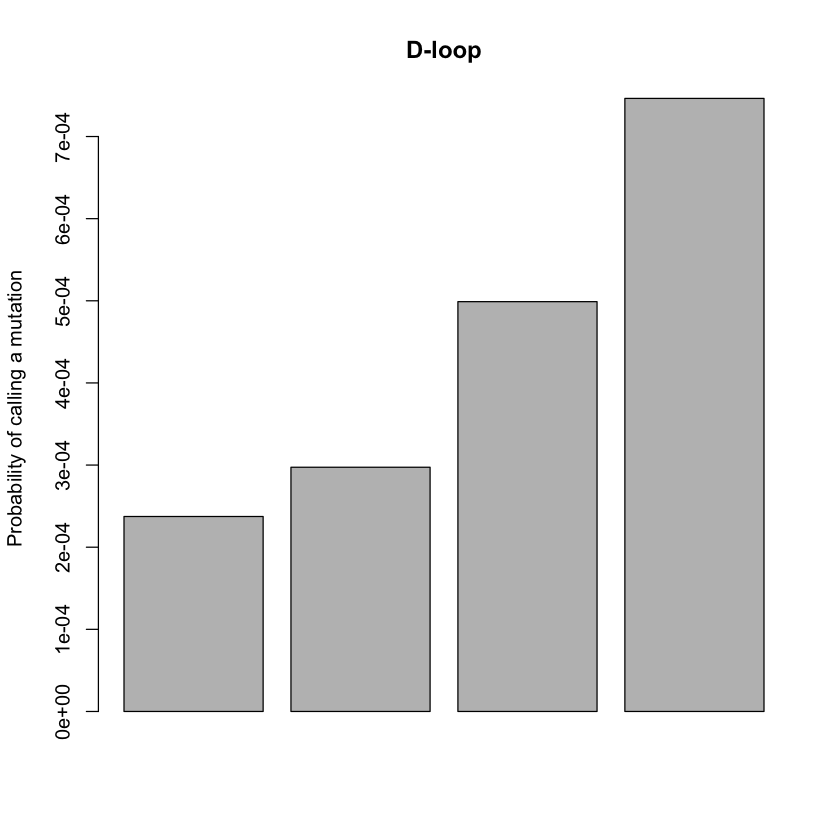

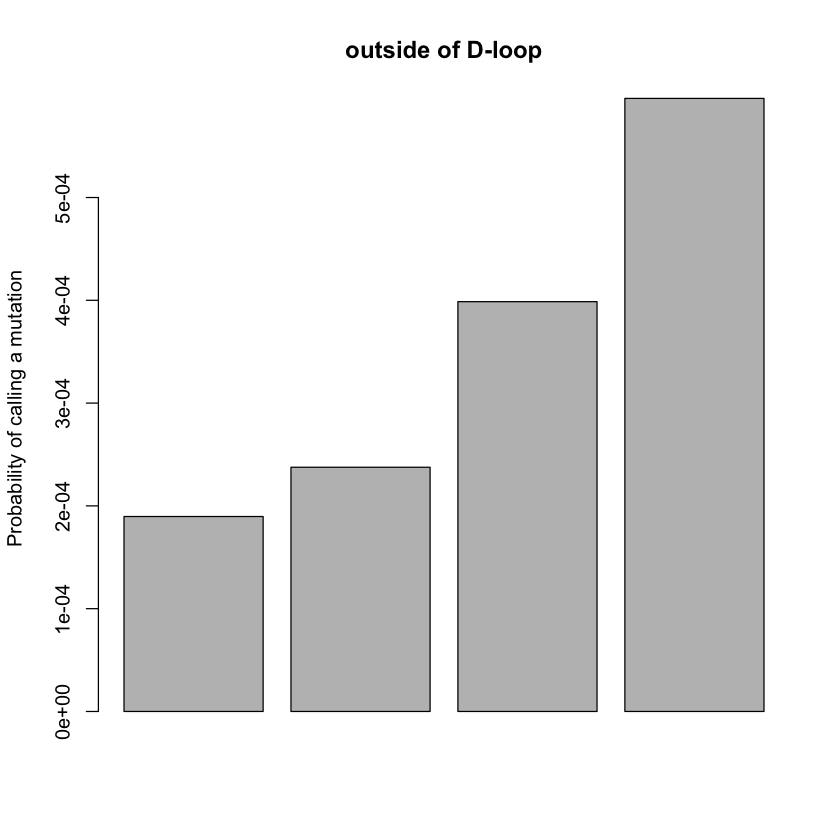

In [53]:
par(bg = "white") # global white backgrounds

barplot(mut_soma2$q_D, ylab = "Probability of calling a mutation", main = "D-loop")
barplot(mut_soma2$q_nonD, ylab = "Probability of calling a mutation", main = "outside of D-loop")

### Probability of observing the same mutation in multiple individuals
We now consider all mutations shared by"Somatic 1"samples of multiple individuals. 

In [54]:
# select only "Somatic 2"
mut_shared_soma2 <- subset(mut_shared_etg, (Tissue == SOMA2) & (Species == SPECIES) )
head(mut_shared_soma2)

,Species,Tissue,mut_hs,Individual,mutation,Region
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
12,human,Sa,hs003_1040_TA_T,hs003,1040_TA_T,non-D
13,human,Sa,hs003_5893_A_AC,hs003,5893_A_AC,non-D
14,human,Sa,hs003_11030_GA_G,hs003,11030_GA_G,non-D
26,human,Sa,hs005_2811_GT_G,hs005,2811_GT_G,non-D
27,human,Sa,hs005_11107_ATATTT_A,hs005,11107_ATATTT_A,non-D
81,human,Sa,hs012_1884_GA_G,hs012,1884_GA_G,non-D


Observed distribution of number of individuals with a certain mutation:

In [55]:
n_indivs_mut_soma2 = table(mut_shared_soma2$mutation)
n_indivs_mut_soma2 = table(factor(n_indivs_mut_soma2, levels = 1:max(n_indivs_mut_soma2)))
n_indivs_mut_soma2


 1  2  3 
19  1  1 

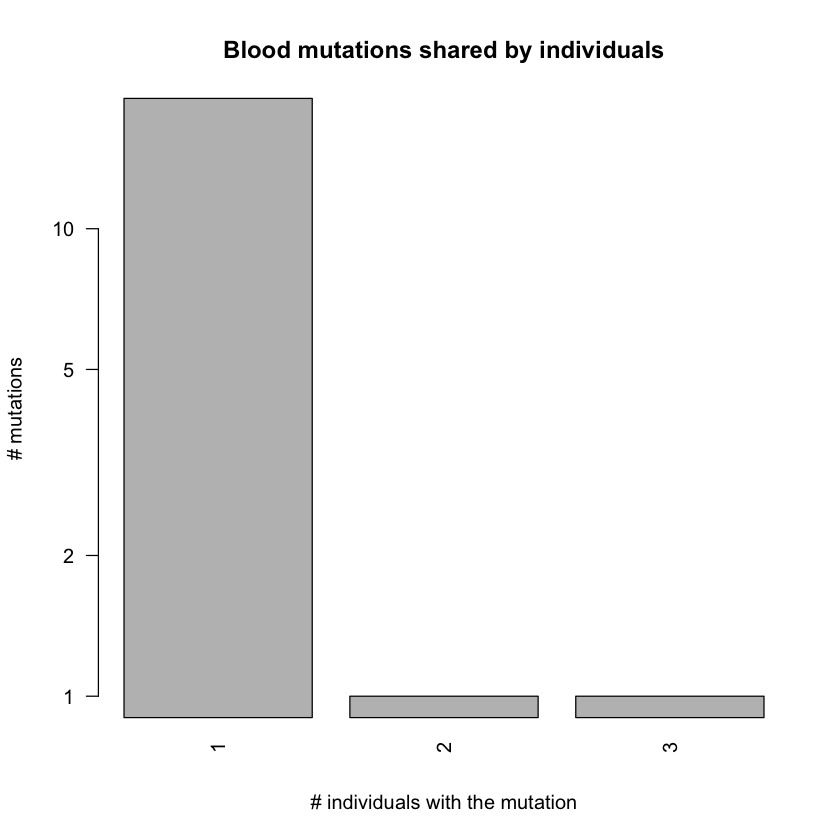

In [56]:
par(bg = "white") # global white backgrounds

n_indivs_mut_soma2_NA = n_indivs_mut_soma2
n_indivs_mut_soma2_NA[n_indivs_mut_soma2_NA==0] = NA
barplot(n_indivs_mut_soma2_NA, log = "y", xlab = "# individuals with the mutation", 
        ylab = "# mutations", main = "Blood mutations shared by individuals", las = 2)

Total number of mutations shared by multiple individuals:

In [57]:
sum(n_indivs_mut_soma2[2:length(n_indivs_mut_soma2)])

[1] 2

Select only mutations shared by multiple individuals:

In [58]:
n_hs = as.data.frame(table(mut_shared_soma2$mutation))
colnames(n_hs) = c("mutation", "n_hs")
mut_shared_soma2 = merge(mut_shared_soma2, n_hs, by = "mutation")
mut_shared_soma2 = mut_shared_soma2[mut_shared_soma2$n_hs>1,]
mut_shared_soma2 = drop_na(mut_shared_soma2)
mut_shared_soma2

mutation,Species,Tissue,mut_hs,Individual,Region,n_hs
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
11030_GA_G,human,Sa,hs012_11030_GA_G,hs012,non-D,3
11030_GA_G,human,Sa,hs003_11030_GA_G,hs003,non-D,3
11030_GA_G,human,Sa,hs023_11030_GA_G,hs023,non-D,3
5893_A_AC,human,Sa,hs003_5893_A_AC,hs003,non-D,2
5893_A_AC,human,Sa,hs023_5893_A_AC,hs023,non-D,2


Check the total number of mutations shared by multiple individuals:

In [59]:
length(unique(mut_shared_soma2$mutation))

[1] 2

Total number of mutations shared by multiple individuals inside and outside D-loop:

In [60]:
mut_shared_soma2_unique = unique(mut_shared_soma2[,c("mutation", "Region")])
c(length(mut_shared_soma2_unique$mutation[mut_shared_soma2_unique$Region=="D-loop"]), 
  length(mut_shared_soma2_unique$mutation[mut_shared_soma2_unique$Region!="D-loop"]))

[1] 0 2

We consider the number of individuals with sequenced"Somatic 1"$n_{hs}=30$. The number of individuals with a mutation in a certain nucleotide is $V = V_1 + \dots + V_{n_{hs}}$ with $V_i \sim B(1, q_i)$. Assuming independence, we can model $V$ with the Poisson binomial distribution $V \sim PB(n_{hs}, q_1, \dots, q_{n_{hs}})$. 
**We can then compute the probability of observing a mutation in one, two or more individuals by random chance as $P(V=v)$ for $v=1, \dots, n_{hs}$**.

In [61]:
n_hs = length(unique(mut_shared_soma2$Individual))
n_hs

prob_shared_soma2_hs = cbind(dpbinom(1:n_hs, probs = mut_soma2$q_D), 
                             dpbinom(1:n_hs, probs = mut_soma2$q_nonD))
colnames(prob_shared_soma2_hs) = c('P(V=v)_D', 'P(V=v)_nonD')
row.names(prob_shared_soma2_hs) = 1:n_hs
prob_shared_soma2_hs

[1] 3

,P(V=v)_D,P(V=v)_nonD
1,1.777897e-03,1.420952e-03
2,1.108107e-06,7.075792e-07
3,2.869559e-10,1.463967e-10


### Expected number of shared mutations
Finally, we can compute the expected number of random mutations present at the same site in one, two or more individuals by multiplying the probability $P(V=v)$ by the mtDNA length (i.e., 1085 nucleotides for D-loop and 15479 nucleotides outside of D-loop for human). 

In [62]:
nt_D = mut_Oo$Region_size_Dloop[1]
nt_nonD = mut_Oo$Region_size_NonDloop[1]

expected_shared_soma2_hs = t(t(prob_shared_soma2_hs) * c(nt_D, nt_nonD))
expected_shared_soma2_hs = cbind(expected_shared_soma2_hs, rowSums(expected_shared_soma2_hs))
colnames(expected_shared_soma2_hs) = c('exp_mut_D', 'exp_mut_nonD', 'exp_mut_tot')
expected_shared_soma2_hs

,exp_mut_D,exp_mut_nonD,exp_mut_tot
1,1.994800e+00,2.194945e+01,2.394425e+01
2,1.243296e-03,1.092998e-02,1.217327e-02
3,3.219645e-07,2.261390e-06,2.583355e-06


Observed number of shared mutations:

In [63]:
shared_soma2_hs = cbind(expected_shared_soma2_hs,n_indivs_mut_soma2_NA)
colnames(shared_soma2_hs)[4] = c("obs_mut_tot")
shared_soma2_hs = as.data.frame(shared_soma2_hs)
shared_soma2_hs$delta = abs(shared_soma2_hs$obs_mut_tot - shared_soma2_hs$exp_mut_tot)
shared_soma2_hs

,exp_mut_D,exp_mut_nonD,exp_mut_tot,obs_mut_tot,delta
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.994800e+00,2.194945e+01,2.394425e+01,19,4.9442481
2,1.243296e-03,1.092998e-02,1.217327e-02,1,0.9878267
3,3.219645e-07,2.261390e-06,2.583355e-06,1,0.9999974


Total number of expected shared mutations:

In [64]:
colSums(shared_soma2_hs[-1,], na.rm = TRUE)

exp_mut_D exp_mut_nonD  exp_mut_tot  obs_mut_tot        delta 
 0.001243618  0.010932238  0.012175856  2.000000000  1.987824144

**We expect to observe around 9 mutation sites shared by different individuals (9 in D-loop and 0 outside D-loop). We actually observe 80 shared sites (XX in D-loop and X outside D-loop).**

pdf 
  2

null device 
          1

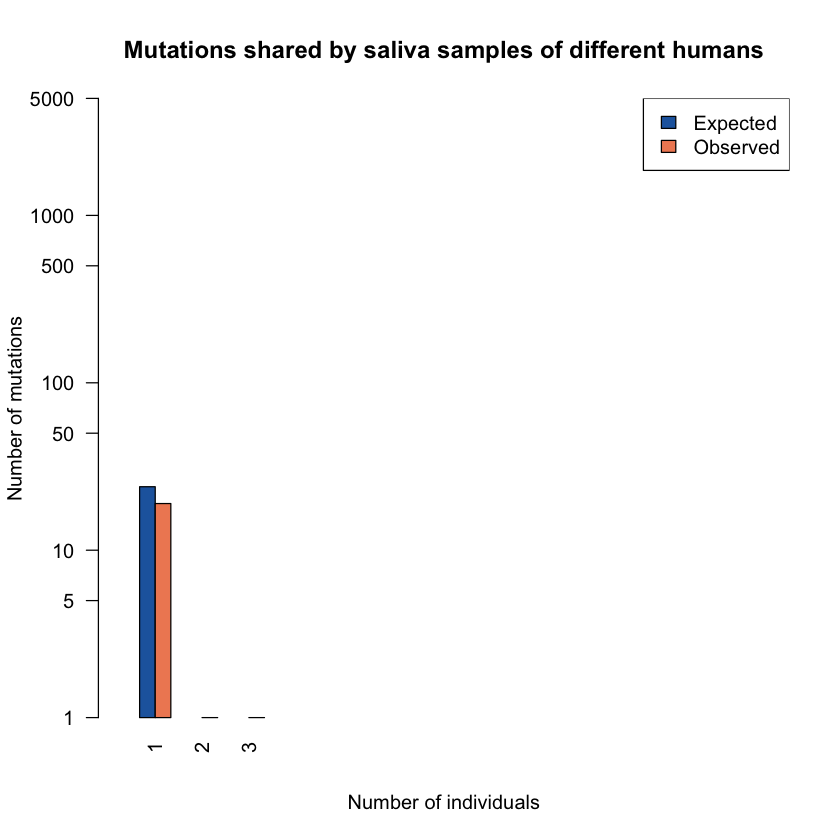

In [65]:
shared_soma2_hs_NA = shared_soma2_hs[,c("exp_mut_tot","obs_mut_tot")]
shared_soma2_hs_NA[shared_soma2_hs_NA<0.5] = NA
shared_soma2_hs_NA[shared_soma2_hs_NA<1 & shared_soma2_hs_NA>0.5] = 1


par(bg = "white") # global white backgrounds

barplot(t(shared_soma2_hs_NA), xlab = "Number of individuals", ylab = "Number of mutations", 
        main = glue("Mutations shared by {SOMA2_NAME} samples of different {SPECIES}s"), log = "y", 
        xlim = c(0,41), ylim = c(1,5000), beside = TRUE, col = custom_palette , las = 2)
legend("topright", legend = c("Expected", "Observed"), fill = custom_palette)

# Output plot.
dev.copy2pdf( file = glue("variantHotspots/barplot_sharedMutations_{ALIGNMENT}_{SPECIES}_{SOMA2}.pdf") )
dev.off()

# Export data table.
write.table(shared_soma2_hs_NA, file = glue("variantHotspots/sharedMutations_{ALIGNMENT}_{SPECIES}_{SOMA2}.txt")
        , sep = "\t", row.names = TRUE, col.names = TRUE)

### Hotspot mutations identification
In order to better identify the hotspot mutations, i.e. the mutations that are shared by multiple individuals but are not expected to be shared, we consider each of 80 shared mutations and we compute the probability of observing it exactly in those individuals in which we are observing it. This way, we can rank the shared mutations based on how unusual they are, taking into consideration in which individuals we found them (hence, also the sequencing depth for each sample). 

For each of the 80 shared mutation, we consider the $n_{hs,i}$ individuals in which we observed it. If the mutation is present in the individuals $j, \dots, j_{n_{hs,i}}$ and is not present in the individuals $k, \dots, k_{n_{hs}-n_{hs,i}}$, assuming independence among random mutations in differentindividuals we obtain that the probability of observing such a mutation in exactly those individuals is $q_j \times \cdots \times q_{j_{n_{hs,i}}} \times (1-q_k) \times \cdots \times (1-q_{k_{n_{hs}-n_{hs,i}}})$. 

In [66]:
mut_shared_soma2_prob = unique(mut_shared_soma2[,c("mutation", "Region", "n_hs")])
mut_shared_soma2_prob$prob = unlist(lapply(unique(mut_shared_soma2$mutation), 
                                           function(mutation){
                                             mut_shared_i = mut_shared_soma2[mut_shared_soma2$mutation==mutation,]
                                             if(mut_shared_i$Region[1]=="D-loop"){
                                               q = mut_soma2$q_D
                                             }else{
                                               q = mut_soma2$q_nonD
                                             }
                                             j = mut_soma2$Individual %in% mut_shared_i$Individual
                                             return(prod(c(q[j], (1-q[!j]))))
                                           }))
mut_shared_soma2_prob = mut_shared_soma2_prob[order(mut_shared_soma2_prob$prob),]
mut_shared_soma2_prob

# Export data table.
write.table(mut_shared_soma2_prob, 
    file = glue("variantHotspots/variantHotspots_{ALIGNMENT}_{SPECIES}_{SOMA2}.txt"), 
    sep = "\t", row.names = TRUE, col.names = TRUE)

,mutation,Region,n_hs,prob
,<chr>,<chr>,<int>,<dbl>
1,11030_GA_G,non-D,3,4.508959e-11
4,5893_A_AC,non-D,2,1.130531e-07
